# Model Monitoring and Alerting with MLflow


## Steps
1. **Data Preparation**: Load the reference and current datasets for monitoring.
2. **Model Training and Logging**: Train a machine learning model and log it to MLflow along with key metrics.
3. **Performance Monitoring**: Track inference time, accuracy, and other performance metrics.
4. **Data Drift Detection**: Identify data drift using statistical tests like the  Kolmogorov-Smirnov (KS) Test.
5. **Alert System**: Configure and trigger alerts for stakeholders via email.
6. **Run Monitoring Pipeline**: Combine all steps into a pipeline and execute monitoring cycles.

In [1]:
!pip install mlflow pandas numpy scikit-learn python-dotenv
!pip install psutil 

In [ ]:
# Start MLflow server in the background terminal
!mlflow server --host 127.0.0.1 --port 5000 

^C


In [11]:
import mlflow
import mlflow.sklearn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import pickle


In [14]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new experiment
mlflow.set_experiment("telecom_price_prediction")

<Experiment: artifact_location='mlflow-artifacts:/173020914166262093', creation_time=1736411258277, experiment_id='173020914166262093', last_update_time=1736411258277, lifecycle_stage='active', name='telecom_price_prediction', tags={}>

## Configure MLFlow


In [15]:
# Load and prepare data
df = pd.read_csv('dataset.csv')
X = df.drop('monthly_charges', axis=1)
y = df['monthly_charges']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the scaler
scaler = StandardScaler()


# Model Training

In [19]:
def train_model():
    # Set MLflow tracking URI
    mlflow.set_tracking_uri("http://127.0.0.1:5000")
    
    # Create a new experiment
    experiment_name = "telecom_price_prediction"
    mlflow.set_experiment(experiment_name)
    
    # Load and prepare data
    df = pd.read_csv('dataset.csv')
    X = df.drop('monthly_charges', axis=1)
    y = df['monthly_charges']
    
    # Split the data
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Initialize the scaler
    scaler = StandardScaler()
    
    # Start MLflow run
    with mlflow.start_run(run_name="linear_regression_model") as run:
        # Log parameters
        mlflow.log_param("model_type", "LinearRegression")
        mlflow.log_param("train_size", len(X_train))
        mlflow.log_param("test_size", len(X_val))
        
        # Fit and transform the training data
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)
        
        # Create and train the model
        model = LinearRegression()
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        y_pred = model.predict(X_val_scaled)
        
        # Calculate metrics
        mse = np.mean((y_val - y_pred) ** 2)
        rmse = np.sqrt(mse)
        r2 = model.score(X_val_scaled, y_val)
        
        # Log metrics
        mlflow.log_metric("rmse", rmse)
        mlflow.log_metric("r2", r2)
        mlflow.log_metric("mse", mse)
        
        # Log feature importances
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Coefficient': model.coef_
        })
        
        # Log the model
        mlflow.sklearn.log_model(model, "model")
        
        # Save the scaler with the model
        with open('scaler.pkl', 'wb') as f:
            pickle.dump(scaler, f)
        mlflow.log_artifact('scaler.pkl')
        
        # Print results
        print("\nModel Performance Metrics:")
        print(f"R-squared Score: {r2:.4f}")
        print(f"Root Mean Square Error: ${rmse:.2f}")
        
        # Return the run ID
        return run.info.run_id

# Monitoring function to track model predictions

In [20]:
def predict_charges_from_csv(test_csv_path, run_id):
    try:
        with mlflow.start_run(run_id=run_id):
            # Load the model from MLflow
            model_uri = f"runs:/{run_id}/model"
            model = mlflow.sklearn.load_model(model_uri)
            
            # Load the scaler
            client = mlflow.tracking.MlflowClient()
            scaler_path = client.download_artifacts(run_id, "scaler.pkl")
            with open(scaler_path, 'rb') as f:
                scaler = pickle.load(f)
            
            # Load test data
            test_data = pd.read_csv(test_csv_path)
            
            # Scale the features
            test_scaled = scaler.transform(test_data)
            
            # Make predictions
            predictions = model.predict(test_scaled)
            
            # Add predictions to the test data
            test_data['predicted_monthly_charges'] = predictions.round(2)
            
            # Save results
            output_file = 'predictions_results.csv'
            test_data.to_csv(output_file, index=False)
            mlflow.log_artifact(output_file)
            
            print(f"\nPredictions have been saved to {output_file}")
            print("\nFirst few predictions:")
            print(test_data[['internet_speed', 'num_services', 'predicted_monthly_charges']])
            
            return test_data
            
    except Exception as e:
        print(f"Error during prediction: {str(e)}")
        return None


In [21]:
# Train the model and get the run_id
run_id = train_model()
print(f"MLflow Run ID: {run_id}")

# Make predictions using the run_id
predictions = predict_charges_from_csv('test.csv', run_id)


Model Performance Metrics:
R-squared Score: 0.9936
Root Mean Square Error: $3.83
MLflow Run ID: 3843abd066ad45fda8213acc56e11efe

Predictions have been saved to predictions_results.csv

First few predictions:
    internet_speed  num_services  predicted_monthly_charges
0            423.4             2                      85.65
1            678.9             3                     132.91
2            234.5             1                      52.46
3            845.6             4                     181.68
4            156.7             2                      43.24
5            567.8             3                     114.18
6            345.6             2                      82.62
7            789.4             4                     165.97
8            123.4             1                      29.30
9            634.5             3                     129.46
10           289.4             2                      68.69
11           512.3             3                     104.74
12        

# Monitoring Config to track model predictions

In [3]:
import json
import datetime
import time

In [4]:
def setup_monitoring_config():
    """Create monitoring configuration"""
    config = {
        "model_monitoring": {
            "metrics": {
                "accuracy_threshold": 0.95,
                "latency_threshold": 100,  # milliseconds
                "prediction_drift_threshold": 0.1,
                "data_drift_threshold": 0.05
            },
            "monitoring_frequency": {
                "performance": "hourly",
                "drift": "daily",
                "data_quality": "hourly"
            },
            "alerts": {
                "email": {
                    "enabled": True,
                    "recipients": ["team@example.com"]
                },
                "slack": {
                    "enabled": False,
                    "channel": "#model-alerts"
                }
            }
        }
    }
    
    # Save config
    with open('monitoring_config.json', 'w') as f:
        json.dump(config, f, indent=4)
    
    return config

# Create Performance Monitoring Function

In [5]:
def monitor_model_performance(model, test_data, actual_values, run_id):
    """Monitor model performance metrics"""
    with mlflow.start_run(run_id=run_id, nested=True):
        try:
            start_time = time.time()
            predictions = model.predict(test_data)
            inference_time = (time.time() - start_time) * 1000  # Convert to ms
            
            # Calculate metrics
            performance_metrics = {
                "accuracy": model.score(test_data, actual_values),
                "latency": inference_time,
                "timestamp": datetime.datetime.now().isoformat()
            }
            
            # Log metrics to MLflow
            mlflow.log_metrics(performance_metrics)
            
            return performance_metrics
            
        except Exception as e:
            print(f"Error in performance monitoring: {str(e)}")
            return None

# Data Drift Detection

In [6]:
from scipy.stats import ks_2samp

def monitor_data_drift(reference_data, current_data, config, run_id):
    """Monitor for data drift using Kolmogorov-Smirnov test"""
    with mlflow.start_run(run_id=run_id, nested=True):
        drift_metrics = {}
        
        for column in reference_data.columns:
            # Perform KS test
            ks_statistic, p_value = ks_2samp(
                reference_data[column],
                current_data[column]
            )
            
            drift_metrics[f"{column}_drift_score"] = ks_statistic
            drift_metrics[f"{column}_p_value"] = p_value
            
            # Log drift metrics
            mlflow.log_metrics(drift_metrics)
            
            # Check for significant drift
            if ks_statistic > config["model_monitoring"]["metrics"]["data_drift_threshold"]:
                print(f"Warning: Significant drift detected in feature {column}")
                
        return drift_metrics

# Create Alert System

In [7]:
def create_alert(alert_type, message, config, email_credentials):
    """Generate and send alerts based on monitoring results"""
    
    timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    
    if alert_type == "performance":
        subject = "⚠️ Model Performance Alert"
    elif alert_type == "drift":
        subject = "🔄 Data Drift Alert"
    else:
        subject = "📊 Model Monitoring Alert"
    
    # Format the message
    formatted_message = f"""
    ML Model Monitoring Alert
    -------------------------
    Type: {alert_type}
    Time: {timestamp}
    
    Details:
    {message}
    
    -------------------------
    This is an automated alert from your ML Model Monitoring System.
    """
    
    if config["model_monitoring"]["alerts"]["email"]["enabled"]:
        send_email_alert(
            subject=subject,
            message=formatted_message,
            recipient_email=email_credentials['recipient_email'],
            sender_email=email_credentials['sender_email'],
            app_password=email_credentials['app_password']
        )



import smtplib
from email.mime.text import MIMEText
from email.mime.multipart import MIMEMultipart


def send_email_alert(subject, message, recipient_email, sender_email, app_password):
    """
    Send email alerts using Gmail SMTP
    
    Parameters:
    - subject: Email subject
    - message: Email body
    - recipient_email: Recipient's email address
    - sender_email: Your Gmail address
    - app_password: Your Gmail App Password
    """
    try:
        # Create message
        msg = MIMEMultipart()
        msg['From'] = sender_email
        msg['To'] = recipient_email
        msg['Subject'] = subject

        # Add body
        msg.attach(MIMEText(message, 'plain'))

        # Create SMTP session
        server = smtplib.SMTP('smtp.gmail.com', 587)
        server.starttls()
        
        # Login
        server.login(sender_email, app_password)
        
        # Send email
        server.send_message(msg)
        
        # Close session
        server.quit()
        
        print("Alert email sent successfully!")
        
    except Exception as e:
        print(f"Error sending email: {str(e)}")

In [8]:
def test_email_alert():
    # Your Gmail credentials
    SENDER_EMAIL = "testingalert.notebook@gmail.com"  # Replace with your Gmail
    APP_PASSWORD = 'xynr gfej pexz nreq'     # Replace with your app password
    RECIPIENT_EMAIL = "testingalert.notebook@gmail.com" # Replace with recipient email

    # Test message
    subject = "ML Model Monitoring Test Alert"
    message = """
    This is a test alert from your ML Model Monitoring System.
    
    Test Details:
    - Timestamp: {}
    - System: Model Monitoring
    - Status: Test Alert
    
    If you received this email, your alert system is working correctly.
    """.format(datetime.datetime.now())

    # Send test email
    send_email_alert(
        subject=subject,
        message=message,
        recipient_email=RECIPIENT_EMAIL,
        sender_email=SENDER_EMAIL,
        app_password=APP_PASSWORD
    )

In [45]:
test_email_alert()

Alert email sent successfully!


In [9]:
def run_monitoring_pipeline(model, reference_data, run_id, email_credentials):
    """
    Main monitoring pipeline for ML model
    
    Parameters:
    - model: Trained ML model
    - reference_data: Original training data for drift comparison
    - run_id: MLflow run ID
    - email_credentials: Dictionary containing email configuration
    """
    
    # Load configuration
    config = setup_monitoring_config()
    
    print(f"Starting monitoring pipeline for model run: {run_id}")
    print("Monitoring configuration loaded successfully")
    
    while True:
        try:
            current_timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
            print(f"\nMonitoring cycle started at: {current_timestamp}")
            
            # 1. Load current data (this would be your production data)
            try:
                current_data = pd.read_csv('test.csv')
                print(f"Loaded current data: {len(current_data)} records")
            except Exception as e:
                error_msg = f"Error loading current data: {str(e)}"
                create_alert("error", error_msg, config, email_credentials)
                raise Exception(error_msg)

            # 2. Monitor Performance
            with mlflow.start_run(run_id=run_id, nested=True) as performance_run:
                print("Monitoring model performance...")
                
                performance_metrics = {
                    'timestamp': current_timestamp,
                    'prediction_count': len(current_data),
                    'latency': []
                }
                
                # Measure prediction latency
                start_time = time.time()
                predictions = model.predict(current_data.drop('monthly_charges', axis=1, errors='ignore'))
                latency = (time.time() - start_time) * 1000  # Convert to milliseconds
                performance_metrics['latency'] = latency
                
                # Log performance metrics
                mlflow.log_metrics({
                    'prediction_latency_ms': latency,
                    'prediction_count': performance_metrics['prediction_count']
                })
                
                # Check latency threshold
                if latency > config['model_monitoring']['metrics']['latency_threshold']:
                    alert_msg = f"High prediction latency detected: {latency:.2f}ms (threshold: {config['model_monitoring']['metrics']['latency_threshold']}ms)"
                    create_alert("performance", alert_msg, config, email_credentials)

            # 3. Monitor Data Drift
            with mlflow.start_run(run_id=run_id, nested=True) as drift_run:
                print("Monitoring data drift...")
                drift_metrics = {}
                
                for column in reference_data.columns:
                    if column in current_data.columns:
                        # Calculate KS statistic
                        ks_statistic, p_value = ks_2samp(
                            reference_data[column],
                            current_data[column]
                        )
                        
                        drift_metrics[f"{column}_drift"] = ks_statistic
                        drift_metrics[f"{column}_drift_pvalue"] = p_value
                        
                        # Check for significant drift
                        if ks_statistic > config['model_monitoring']['metrics']['data_drift_threshold']:
                            alert_msg = f"Significant drift detected in feature {column} (KS statistic: {ks_statistic:.3f})"
                            create_alert("drift", alert_msg, config, email_credentials)
                
                # Log drift metrics
                mlflow.log_metrics(drift_metrics)

            # 4. Data Quality Checks
            with mlflow.start_run(run_id=run_id, nested=True) as quality_run:
                print("Performing data quality checks...")
                quality_metrics = {
                    'missing_values': current_data.isnull().sum().sum(),
                    'negative_values': (current_data < 0).sum().sum()
                }
                
                # Log quality metrics
                mlflow.log_metrics(quality_metrics)
                
                # Check for data quality issues
                if quality_metrics['missing_values'] > 0:
                    alert_msg = f"Missing values detected: {quality_metrics['missing_values']} values"
                    create_alert("data_quality", alert_msg, config, email_credentials)

            # 5. Prediction Distribution Monitoring
            with mlflow.start_run(run_id=run_id, nested=True) as pred_run:
                print("Monitoring prediction distribution...")
                
                pred_metrics = {
                    'pred_mean': np.mean(predictions),
                    'pred_std': np.std(predictions),
                    'pred_min': np.min(predictions),
                    'pred_max': np.max(predictions)
                }
                
                # Log prediction distribution metrics
                mlflow.log_metrics(pred_metrics)
                
                # Check for prediction distribution anomalies
                if pred_metrics['pred_std'] > 2 * reference_data['monthly_charges'].std():
                    alert_msg = "Unusual prediction distribution detected"
                    create_alert("prediction", alert_msg, config, email_credentials)

            print(f"Monitoring cycle completed successfully")
            print(f"Next check in {config['model_monitoring']['monitoring_frequency']['performance']} seconds")
            
            # Wait for next monitoring interval
            if config['model_monitoring']['monitoring_frequency']['performance'] == 'hourly':
                time.sleep(3600)  # 1 hour
            else:
                time.sleep(86400)  # 1 day
                
        except Exception as e:
            error_msg = f"Error in monitoring pipeline: {str(e)}"
            print(error_msg)
            create_alert("error", error_msg, config, email_credentials)
            time.sleep(300) 

In [12]:
import mlflow
import mlflow.sklearn

In [17]:
# Set MLflow tracking URI
mlflow.set_tracking_uri("http://127.0.0.1:5000")

# Create a new experiment
mlflow.set_experiment("telecom_price_prediction")

<Experiment: artifact_location='mlflow-artifacts:/173020914166262093', creation_time=1736411258277, experiment_id='173020914166262093', last_update_time=1736411258277, lifecycle_stage='active', name='telecom_price_prediction', tags={}>

In [18]:
run_id = '3843abd066ad45fda8213acc56e11efe'
model_uri = f"runs:/{run_id}/model"
model = mlflow.sklearn.load_model(model_uri)

In [ ]:
# Usage example:
if __name__ == "__main__":
    try:
        # Email credentials
        email_credentials = {
            'sender_email': 'testingalert.notebook@gmail.com',
            'app_password': 'xynr gfej pexz nreq',
            'recipient_email': 'testingalert.notebook@gmail.com'
        }

        # Load your model and reference data
        reference_data = pd.read_csv('dataset.csv')
        
        # Get your MLflow run ID
        run_id = '3843abd066ad45fda8213acc56e11efe'  # Replace with actual run ID
        
        # Start the monitoring pipeline
        run_monitoring_pipeline(model, reference_data, run_id, email_credentials)
        
    except Exception as e:
        print(f"Failed to start monitoring pipeline: {str(e)}")

Starting monitoring pipeline for model run: 3843abd066ad45fda8213acc56e11efe
Monitoring configuration loaded successfully

Monitoring cycle started at: 2025-01-09 15:41:51
Loaded current data: 25 records
Monitoring model performance...


c:\Users\Ujjaval\anaconda3\envs\pythonProject\lib\site-packages\sklearn\base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


Monitoring data drift...
Alert email sent successfully!
Alert email sent successfully!
Alert email sent successfully!
Alert email sent successfully!
Performing data quality checks...
Monitoring prediction distribution...
Alert email sent successfully!
Monitoring cycle completed successfully
Next check in hourly seconds


![alt text](image.png)

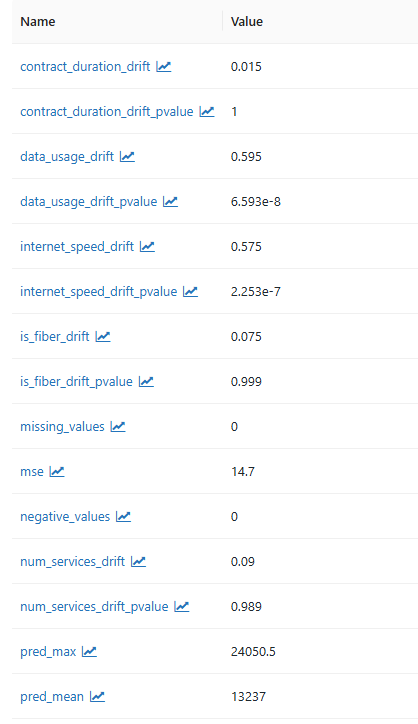